In [1]:
# conda install -c conda-forge jupyter_contrib_nbextensions

# Progetto Finale di Introduzione alla Data Science
Autore: **Lorenzo La Corte** - S4784539

Dataset: **Google Play Store Apps**

--------------------------------------------------------------------------------------------------------------------


## Gradimento delle App Gratuite o a Pagamento



**Obiettivo dell'analisi:**
Studiare le criticità e i punti di forza di app a pagamento e di app gratuite con pubblicità.


**Nel dettaglio:**
Cerco con questa analisi di capire se è possibile che il prezzo di un'applicazione influenzi il rating e il numero di review;
Immagino infatti che un acquirente di un'app a pagamento sia piu' stimolato a lasciare una recensione, per comunicare agli altri se il prodotto vale o meno la spesa.
Inoltre ritengo che se un'applicazione a pagamento viene ritenuta scadente, chi l'ha acquistata sarà molto piu' spronato a lasciare una recensione negativa mentre per una scadente ma gratuita, è piu' probabile che essa venga solo disinstallata. 
Allo stesso tempo, per monetizzare app gratuite sono necessarie pubblicità; ipotizzo che se queste siano troppe o troppo invasive possano portare a rating negativi.


**Ipotesi:**
Le ipotesi sono quindi che:
1. - le app gratuite siano piu' gradite in generale delle app a pagamento.
2. - in proporzione alle installazioni, le app a pagamento siano piu' recensite di quelle gratuite.
3. - nelle app gratuite, le pubblicità troppo invasive portano a recensioni negative.

## Operazioni Preliminari

Importo le librerie di base:

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats as stats
# !pip install scipy==1.7.0
import scipy
print (scipy.__version__)

1.7.1


Importo il dataset:

In [3]:
playstore = pd.read_csv('googleplaystore.csv') # importo il file
playstore.head() # visualizza le prime entry del dataset

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Visualizzo numero di righe e di caratteristiche.

In [4]:
playstore.shape # restituisce (numero di righe, numero di colonne)

(10841, 13)

## Pulizia del Dataset 

Divido il dataset in features qualitative e quantitative:

In [5]:
# la [[]] crea dataframe con sezioni di caratteristiche
quantitative_playstore = playstore[['Rating','Reviews','Size','Installs','Price']] 
qualitative_playstore = playstore[['App','Category','Type','Content Rating','Genres', 'Last Updated', 'Current Ver', 'Android Ver']]

Adesso utilizzo il metodo describe() e noto che esso mi restituisce solo Rating come variabile quantitativa.



In [6]:
playstore.describe() # mi dovrebbe dare la stessa cosa (solo le quantitative)

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


Probabilmente devo pulire la tabella in modo da rendere 'Reviews', 'Size', 'Installs', 'Price' quantitative.

Quindi:
1. Gestire i valori nulli se ci sono,
2. Rimuovere il '+' da 'Installs' per renderlo quantitativo,
3. Scoprire perché reviews e price non sono quantitative,
4. Eliminazione dei duplicati.

Anche la size risulta non quantitativa: la colonna è composta da stringhe; in questo caso non gestisco questa caratteristica in quanto non mi sembra utile alle analisi; gestisco invece le altre features.

## Gestione dei Valori Nulli

In [7]:
qualitative_playstore.describe()

,App,Category,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,10841,10841,10840,10840,10841,10841,10833,10838
unique,9660,34,3,6,120,1378,2832,33
top,ROBLOX,FAMILY,Free,Everyone,Tools,"August 3, 2018",Varies with device,4.1 and up
freq,9,1972,10039,8714,842,326,1459,2451


Notiamo che le colonne hanno piu' o meno tutte lo stesso valore per count, quindi possiamo immaginare ci siano pochi valori nulli per le variabili quantitative, mentre i rating sembrano essere circa mille in meno; verifichiamo con:

In [8]:
playstore.isnull().sum() # ci da tutte le occorrenze nulle

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

Prendiamo in considerazione quindi la colonna "Rating". Abbiamo due soluzioni:
1. Eliminare le righe con elementi nulli oppure
2. Provare a completarle. 

In [9]:
# Soluzione 2 (per Rating)
average_rating = playstore['Rating'].mean()
playstore['Rating'].fillna(average_rating, inplace = True) # completa i mancanti con la media degli altri

# Soluzione 1 (per i pochi altri valori nulli)
playstore.dropna(how ='any', inplace = True)

# Risultato
playstore.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

Ho quindi adottato la soluzione del completamento per Rating e di eliminazione per gli altri valori nulli.

## Gestione delle Variabili Quantitative
Rimuovo il '+' da 'Installs' per renderlo quantitativo:

In [10]:
if(type(playstore['Installs'][0]) is str):
    playstore = playstore[playstore.Installs != "Free"] # rimuovo le righe con questo valore per Installs
    playstore['Installs'] = [float(x.replace("+","").replace(",",".").replace(".","")) for x in playstore['Installs']]
    
playstore.describe()

,Rating,Installs
count,10829.000000,1.082900e+04
mean,4.192041,1.547990e+07
std,0.479038,8.507114e+07
min,1.000000,0.000000e+00
25%,4.100000,5.000000e+03
50%,4.200000,1.000000e+05
75%,4.500000,5.000000e+06
max,5.000000,1.000000e+09


Analizzo ora le feature Reviews, Price e Type, guardando il loro tipo:

In [11]:
print(type(playstore['Reviews'][0]))
print(type(playstore['Price'][0]))
print(type(playstore['Type'][0]))

<class 'str'>
<class 'str'>
<class 'str'>


Devo convertirle anch'esse al fine di renderle quantitative:

In [12]:
if(type(playstore['Reviews'][0]) is str):
    playstore['Reviews'] = [float(x.replace("M","000000")) for x in playstore['Reviews']]

if(type(playstore['Price'][0]) is str):
    playstore = playstore[playstore.Price != "Everyone"] # rimuovo le righe con questo valore per Price
    playstore['Price'] = [float(x.replace("$","")) for x in playstore['Price']]

if(type(playstore['Type'][0]) is str):
    playstore['Type'] = [int(x.replace("Free","0").replace("Paid","1")) for x in playstore['Type']]

playstore.describe()

,Rating,Reviews,Installs,Type,Price
count,10829.000000,1.082900e+04,1.082900e+04,10829.000000,10829.000000
mean,4.192041,4.446018e+05,1.547990e+07,0.073599,1.028091
std,0.479038,2.929213e+06,8.507114e+07,0.261129,15.957778
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,4.100000,3.800000e+01,5.000000e+03,0.000000,0.000000
50%,4.200000,2.100000e+03,1.000000e+05,0.000000,0.000000
75%,4.500000,5.481500e+04,5.000000e+06,0.000000,0.000000
max,5.000000,7.815831e+07,1.000000e+09,1.000000,400.000000


## Elimazione Duplicati
Come ultimo guardo se ci sono duplicati nel dataset e nel caso li rimuovo.

In [13]:
playstore[playstore.duplicated(['App'])]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805.0,Varies with device,5000000.0,0,0.0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
236,Box,BUSINESS,4.2,159872.0,Varies with device,10000000.0,0,0.0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
239,Google My Business,BUSINESS,4.4,70991.0,Varies with device,5000000.0,0,0.0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614.0,37M,10000000.0,0,0.0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up
261,join.me - Simple Meetings,BUSINESS,4.0,6989.0,Varies with device,1000000.0,0,0.0,Everyone,Business,"July 16, 2018",4.3.0.508,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10715,FarmersOnly Dating,DATING,3.0,1145.0,1.4M,100000.0,0,0.0,Mature 17+,Dating,"February 25, 2016",2.2,4.0 and up
10720,Firefox Focus: The privacy browser,COMMUNICATION,4.4,36981.0,4.0M,1000000.0,0,0.0,Everyone,Communication,"July 6, 2018",5.2,5.0 and up
10730,FP Notebook,MEDICAL,4.5,410.0,60M,50000.0,0,0.0,Everyone,Medical,"March 24, 2018",2.1.0.372,4.4 and up
10753,Slickdeals: Coupons & Shopping,SHOPPING,4.5,33599.0,12M,1000000.0,0,0.0,Everyone,Shopping,"July 30, 2018",3.9,4.4 and up


Sembrano esserci molte app duplicate; ne analizzo una:

In [14]:
playstore[playstore['App']=="ZOOM Cloud Meetings"]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
213,ZOOM Cloud Meetings,BUSINESS,4.4,31614.0,37M,10000000.0,0,0.0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614.0,37M,10000000.0,0,0.0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up


Effettivamente lo è; elimino quindi tutti i duplicati presenti nel dataset.

In [15]:
playstore = playstore.drop_duplicates(keep='last',subset=['App'])

Guardo ora il datastet:

In [16]:
print(playstore.shape)
playstore.describe()

(9648, 13)


,Rating,Reviews,Installs,Type,Price
count,9648.000000,9.648000e+03,9.648000e+03,9648.000000,9648.000000
mean,4.176325,2.168957e+05,7.802970e+06,0.077840,1.098122
std,0.494198,1.831767e+06,5.379994e+07,0.267933,16.861193
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,4.000000,2.500000e+01,1.000000e+03,0.000000,0.000000
50%,4.200000,9.740000e+02,1.000000e+05,0.000000,0.000000
75%,4.500000,2.944925e+04,1.000000e+06,0.000000,0.000000
max,5.000000,7.812821e+07,1.000000e+09,1.000000,400.000000


Abbiamo rimosso circa duemila righe ma i valori ora hanno un senso e il dataset è pulito e ordinato: siamo pronti ad una prima analisi delle feature.

# Analisi delle Feature

Cerchiamo di analizzare alcune features, per estrapolare interessanti informazioni su di esse e le loro correlazioni. 

Andiamo inanzitutto a dare un'occhiata alla tabella delle correlazioni.

In [17]:
playstore.corr().style.background_gradient(cmap="Blues")

,Rating,Reviews,Installs,Type,Price
Rating,1.000000,0.054332,0.039240,0.042410,-0.019331
Reviews,0.054332,1.000000,0.625023,-0.033011,-0.007594
Installs,0.039240,0.625023,1.000000,-0.041728,-0.009414
Type,0.042410,-0.033011,-0.041728,1.000000,0.224175
Price,-0.019331,-0.007594,-0.009414,0.224175,1.000000


Notiamo una correlazione tra Reviews e Installs e una leggera correlazione tra Prezzo e Tipo dell'applicazione (gratuita o a pagamento).

# 1. Analisi su Rating di App Gratuite o a Pagamento
In questa prima analisi ci concentriamo principalmente sulle feature Rating e Price, pondendoci 3 domande:

1. Qual'è la distribuzione dei Rating?

2. Qual'è la percentuale di app a pagamento e app gratuite?

3. T-Test: le app gratuite sono piu' gradite di quelle a pagamento?



<AxesSubplot:>

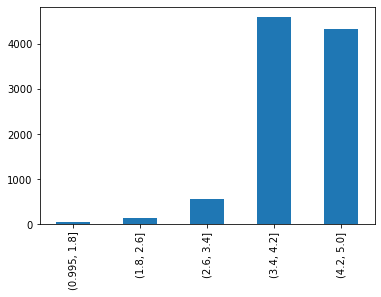

In [18]:
Ratings = playstore['Rating']
Ratings = Ratings.value_counts(bins=5, sort=False) # divido in 20 classi di prezzo 
Ratings.plot(kind = 'bar')

Notiamo che la maggior parte delle valutazioni degli utenti sono positive.

Andiamo ora ad osservare la percentuale di app a pagamento e app gratuite.

In [19]:
free_apps = playstore[playstore['Type']==0]
paid_apps = playstore[playstore['Type']==1]

perc_app_gratis = len(free_apps) / playstore.shape[0]
perc_app_pagate = len(paid_apps) / playstore.shape[0]

print("Percentuale di app gratis: " + str(perc_app_gratis))
print("Percentuale di app a pagamento: " + str(perc_app_pagate))

Percentuale di app gratis: 0.9221600331674958
Percentuale di app a pagamento: 0.07783996683250415


Osserviamo che la maggior parte delle applicazioni sono gratuite.

### T-Test: le app gratuite sono piu' gradite di quelle a pagamento?

Formuliamo ora un'ipotesi circa il gradimento di app gratuite e a pagamento, usando la seguente notazione:

H0 = "il gradimento delle app gratuite è maggiore del gradimento delle app a pagamento". 

A questo punto l'ipotesi alternativa è:

HA = "il gradimento delle app gratuite è minore del gradimento delle app a pagamento". 

Usiamo un **t-test a una coda** per verificare se l'ipotesi nulla è corretta.

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi n > 30: considero un campione di 500 elementi;
2. Popolazione N almeno dieci volte superiore al campione: N > 10\*n: N=9135 > 10\*500

In [20]:
campione = free_apps['Rating'].sample(n = 500) # prendo un campione di 500 app scelte casualmente
print("Grandezza campione:\t\t " + str(campione.shape))
print("Media sul campione:\t\t " + str(np.mean(campione)))

popolazione_pagamento = paid_apps['Rating']
print("Popolazione restante:\t\t " + str(popolazione_pagamento.shape))
print("Media sulla popolazione restante: " + str(np.mean(popolazione_pagamento)))

Grandezza campione:		 (500,)
Media sul campione:		 4.158600747304376
Popolazione restante:		 (751,)
Media sulla popolazione restante: 4.248460833048903


Le due condizioni sono verificate, eseguiamo quindi il t-test usando la libreria scipy. 

Scegliamo un livello di confidenza pari a 95%: il livello di significatività è 0.05.

In [21]:
t_statistic, p_value = stats.ttest_1samp(a= campione, popmean= popolazione_pagamento.mean(),alternative='less')
print("Eseguo un test sulle app gratuite con media dei Rating maggiore (poiché alternative è less) della media delle app a pagamento.")
print("Statistica del Test: " + str(t_statistic))
print("p-value calcolato: " + str(p_value))

Eseguo un test sulle app gratuite con media dei Rating maggiore (poiché alternative è less) della media delle app a pagamento.
Statistica del Test: -3.935678173214883
p-value calcolato: 4.7368964687323314e-05


*p-value < livello di significatività*

H0 è quindi rigettata, mentre accettiamo HA;
quindi **il gradimento delle app gratuite è minore del gradimento delle app a pagamento**.

# 2. Analisi su Installazioni e Recensioni di App Gratuite o a Pagamento.

Ipotesi: In proporzione alle installazioni, le app a pagamento siano piu' recensite di quelle a pagamento.

Creo una colonna che indica il rapporto tra numero di recensioni e numero di installazioni.

In [22]:
rew_ratio_values = playstore["Reviews"].div(playstore["Installs"])
playstore["Review Ratio"] = rew_ratio_values
playstore.dropna(how ='any', inplace = True)

In [23]:
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Review Ratio
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,10000.0,0,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,0.015900
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,5000000.0,0,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,0.017502
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25M,50000000.0,0,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,0.004313
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8M,100000.0,0,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,0.009670
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167.0,5.6M,50000.0,0,0.0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,0.003340


### T-Test: le app a pagamento hanno un rapporto Review/Installazioni piu' alto di quelle gratuite?

Formuliamo ora un'ipotesi circa il gradimento di app gratuite e a pagamento, usando la seguente notazione:

H0 = "le app a pagamento hanno un rapporto Review/Installazioni piu' alto di quelle a pagamento". 

A questo punto l'ipotesi alternativa è:

H0 = "le app gratuite hanno un rapporto Review/Installazioni piu' alto di quelle gratuite". 

Usiamo un **t-test a una coda** per verificare se l'ipotesi nulla è corretta.

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.

In [24]:
free_apps = playstore[playstore['Price']==0]
paid_apps = playstore[playstore['Price']>0]

perc_app_gratis = len(free_apps) / playstore.shape[0]
perc_app_pagate = len(paid_apps) / playstore.shape[0]

print("Percentuale di app gratis: " + str(perc_app_gratis))
print("Percentuale di app a pagamento: " + str(perc_app_pagate))

print("\nGrandezza dataset: " + str(playstore.shape[0]))
print("Media del Review Ratio per le app gratuite: \t " + str(free_apps['Review Ratio'].mean()))
print("Media del Review Ratio per le app a pagamento: \t " + str(paid_apps['Review Ratio'].mean()))

campione = free_apps['Review Ratio'].sample(n = 500)
print("\nGrandezza campione:\t\t " + str(campione.shape))
print("Media sul campione:\t\t " + str(np.mean(campione)))

popolazione_restante = paid_apps['Review Ratio']
print("Popolazione restante:\t\t " + str(popolazione_restante.shape))
print("Media sulla popolazione restante: " + str(np.mean(popolazione_restante)))

print("\n\nEseguo un t-test su app gratuite con ratio minore (poiché alternative è greater) di quelle a pagamento:")
t_statistic, p_value = stats.ttest_1samp(a= campione, popmean= popolazione_restante.mean(),alternative='greater')
print("Statistica del Test: " + str(t_statistic))
print("p-value calcolato: " + str(p_value))

Percentuale di app gratis: 0.9230849076188499
Percentuale di app a pagamento: 0.07691509238115009

Grandezza dataset: 9634
Media del Review Ratio per le app gratuite: 	 0.03211026203969388
Media del Review Ratio per le app a pagamento: 	 0.11017516437246958

Grandezza campione:		 (500,)
Media sul campione:		 0.02815863987599996
Popolazione restante:		 (741,)
Media sulla popolazione restante: 0.11017516437246958


Eseguo un t-test su app gratuite con ratio minore (poiché alternative è greater) di quelle a pagamento:
Statistica del Test: -33.811424655700165
p-value calcolato: 1.0


Abbiamo considerato un campione di 500 app gratuite, e di 741 app a pagamento. 

Le condizioni del t-test sono quindi verificate, infatti:
Campione = 500 app gratuite, popolazione totale = 9135, quindi: 500 > 30 e 500\*10 < 9135

*p-value > livello di significatività*

H0 è quindi accettata, quindi **le app a pagamento hanno un rapporto Review/Installazioni piu' alto di quelle gratuite**.

# 3. Correlazione tra Pubblicità nelle App e Recensioni Negative

Vado ora ad effettuare un analisi sulla pubblicità nelle applicazioni, ed in particolare al fatto che essa possa portare a recensioni negative.

Osservo quindi se una data recensione contiene parole inerenti alle pubblicità: se le contiene mi aspetto che la recensione sia negativa (posso anche eventualmente vedere se quell'app fosse gratuita o meno).

Inizio collegando il dataset delle recensioni a quello generale:

In [25]:
ps_reviews = pd.read_csv('googleplaystore_user_reviews.csv') #importo il file

playstore_with_rew = playstore.join(ps_reviews.set_index('App'), on='App')
playstore_with_rew.dropna(how ='any', inplace = True)

playstore_with_rew.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Review Ratio,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,1000000.0,0,0.0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up,0.013791,It's...a coloring book ap. And I like adult co...,Positive,2.166667e-01,0.573810
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,1000000.0,0,0.0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up,0.013791,wanted access pictures. I denied let app. Don'...,Neutral,0.000000e+00,0.000000
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,1000000.0,0,0.0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up,0.013791,Way many ads... im paying 8$USD pictures color...,Positive,3.000000e-01,0.600000
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,1000000.0,0,0.0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up,0.013791,"good bad color outside lines. like real, tradi...",Positive,2.775558e-17,0.579167
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,1000000.0,0,0.0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up,0.013791,I really enjoying application. My complaint sm...,Negative,-3.472222e-02,0.581944


In [26]:
# sulla feature Sentiment trasformo Positive in 1, Neutral in 0.5 e Negative in 0
playstore_with_rew['Sentiment'] = [float(x.replace("Positive","1").replace("Neutral","0.5").replace("Negative","0")) for x in playstore_with_rew['Sentiment']]
    
playstore_with_rew.describe()

,Rating,Reviews,Installs,Type,Price,Review Ratio,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
count,35929.000000,3.592900e+04,3.592900e+04,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000
mean,4.297261,1.413317e+06,4.375691e+07,0.011578,0.109197,0.032909,0.709691,0.180904,0.493767
std,0.302842,5.731737e+06,1.453465e+08,0.106980,1.302471,0.041932,0.415067,0.350080,0.258053
min,2.600000,4.600000e+01,1.000000e+03,0.000000,0.000000,0.000289,0.000000,-1.000000,0.000000
25%,4.100000,1.024700e+04,1.000000e+06,0.000000,0.000000,0.010375,0.500000,0.000000,0.361111
50%,4.300000,6.362400e+04,5.000000e+06,0.000000,0.000000,0.020846,1.000000,0.150000,0.514835
75%,4.500000,5.152400e+05,1.000000e+07,0.000000,0.000000,0.037815,1.000000,0.400000,0.650000
max,4.900000,7.812821e+07,1.000000e+09,1.000000,29.990000,0.448814,1.000000,1.000000,1.000000


In [27]:
playstore_with_rew.corr().style.background_gradient(cmap="Blues")

,Rating,Reviews,Installs,Type,Price,Review Ratio,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
Rating,1.000000,0.075785,0.019964,0.008883,-0.010083,0.286071,0.091491,0.093348,0.068765
Reviews,0.075785,1.000000,0.564232,-0.026381,-0.020592,0.313742,-0.071745,-0.080049,-0.009319
Installs,0.019964,0.564232,1.000000,-0.032436,-0.025201,-0.004381,-0.042383,-0.057868,-0.006320
Type,0.008883,-0.026381,-0.032436,1.000000,0.774633,0.260697,0.027435,0.014730,0.007334
Price,-0.010083,-0.020592,-0.025201,0.774633,1.000000,0.192184,0.025730,0.024148,0.003182
Review Ratio,0.286071,0.313742,-0.004381,0.260697,0.192184,1.000000,-0.009726,-0.045599,0.031601
Sentiment,0.091491,-0.071745,-0.042383,0.027435,0.025730,-0.009726,1.000000,0.751681,0.176329
Sentiment_Polarity,0.093348,-0.080049,-0.057868,0.014730,0.024148,-0.045599,0.751681,1.000000,0.259668
Sentiment_Subjectivity,0.068765,-0.009319,-0.006320,0.007334,0.003182,0.031601,0.176329,0.259668,1.000000


Quindi:
- creo una colonna nuova che è 1 se la recensione contiene una parola inerente alla pubblicità.
- osservo la correlazione tra pubblicità e rating.

In [28]:
words = ["ad", "ads", "advert", "advertising", "publicity"]

# riempio la colonna di zeri
playstore_with_rew['Complains_Adv'] = [0] * playstore_with_rew.shape[0]

playstore_with_rew.describe()

,Rating,Reviews,Installs,Type,Price,Review Ratio,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Complains_Adv
count,35929.000000,3.592900e+04,3.592900e+04,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000,35929.0
mean,4.297261,1.413317e+06,4.375691e+07,0.011578,0.109197,0.032909,0.709691,0.180904,0.493767,0.0
std,0.302842,5.731737e+06,1.453465e+08,0.106980,1.302471,0.041932,0.415067,0.350080,0.258053,0.0
min,2.600000,4.600000e+01,1.000000e+03,0.000000,0.000000,0.000289,0.000000,-1.000000,0.000000,0.0
25%,4.100000,1.024700e+04,1.000000e+06,0.000000,0.000000,0.010375,0.500000,0.000000,0.361111,0.0
50%,4.300000,6.362400e+04,5.000000e+06,0.000000,0.000000,0.020846,1.000000,0.150000,0.514835,0.0
75%,4.500000,5.152400e+05,1.000000e+07,0.000000,0.000000,0.037815,1.000000,0.400000,0.650000,0.0
max,4.900000,7.812821e+07,1.000000e+09,1.000000,29.990000,0.448814,1.000000,1.000000,1.000000,0.0


In [29]:
for i, row in playstore_with_rew.iterrows():

    isPresent = 0

    for word in words:
        if word in str(row['Translated_Review']).split():
            isPresent = 1
            # print("\n" + str(row['Translated_Review']) + "\n" + str(row['Sentiment']) + "\n")

    playstore_with_rew.loc[i, "Complains_Adv"] = isPresent

In [30]:
playstore_with_rew['Complains_Adv'] = [int(x) for x in playstore_with_rew['Complains_Adv']]
    
playstore_with_rew.describe()

,Rating,Reviews,Installs,Type,Price,Review Ratio,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Complains_Adv
count,35929.000000,3.592900e+04,3.592900e+04,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000
mean,4.297261,1.413317e+06,4.375691e+07,0.011578,0.109197,0.032909,0.709691,0.180904,0.493767,0.041471
std,0.302842,5.731737e+06,1.453465e+08,0.106980,1.302471,0.041932,0.415067,0.350080,0.258053,0.199379
min,2.600000,4.600000e+01,1.000000e+03,0.000000,0.000000,0.000289,0.000000,-1.000000,0.000000,0.000000
25%,4.100000,1.024700e+04,1.000000e+06,0.000000,0.000000,0.010375,0.500000,0.000000,0.361111,0.000000
50%,4.300000,6.362400e+04,5.000000e+06,0.000000,0.000000,0.020846,1.000000,0.150000,0.514835,0.000000
75%,4.500000,5.152400e+05,1.000000e+07,0.000000,0.000000,0.037815,1.000000,0.400000,0.650000,0.000000
max,4.900000,7.812821e+07,1.000000e+09,1.000000,29.990000,0.448814,1.000000,1.000000,1.000000,1.000000


Notiamo che **il 4% circa delle recensioni parlano di pubblicità**.

In [31]:
playstore_with_rew.corr().style.background_gradient(cmap="Blues")

,Rating,Reviews,Installs,Type,Price,Review Ratio,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Complains_Adv
Rating,1.000000,0.075785,0.019964,0.008883,-0.010083,0.286071,0.091491,0.093348,0.068765,-0.030387
Reviews,0.075785,1.000000,0.564232,-0.026381,-0.020592,0.313742,-0.071745,-0.080049,-0.009319,-0.034826
Installs,0.019964,0.564232,1.000000,-0.032436,-0.025201,-0.004381,-0.042383,-0.057868,-0.006320,-0.023467
Type,0.008883,-0.026381,-0.032436,1.000000,0.774633,0.260697,0.027435,0.014730,0.007334,-0.022512
Price,-0.010083,-0.020592,-0.025201,0.774633,1.000000,0.192184,0.025730,0.024148,0.003182,-0.017439
Review Ratio,0.286071,0.313742,-0.004381,0.260697,0.192184,1.000000,-0.009726,-0.045599,0.031601,-0.064764
Sentiment,0.091491,-0.071745,-0.042383,0.027435,0.025730,-0.009726,1.000000,0.751681,0.176329,0.003888
Sentiment_Polarity,0.093348,-0.080049,-0.057868,0.014730,0.024148,-0.045599,0.751681,1.000000,0.259668,-0.024217
Sentiment_Subjectivity,0.068765,-0.009319,-0.006320,0.007334,0.003182,0.031601,0.176329,0.259668,1.000000,0.000654
Complains_Adv,-0.030387,-0.034826,-0.023467,-0.022512,-0.017439,-0.064764,0.003888,-0.024217,0.000654,1.000000


Notiamo che non c'è correlazione tra Sentiment e Complains_Adv.

In [32]:
complains_adv = playstore_with_rew[playstore_with_rew['Complains_Adv']==1]

s_negative = playstore_with_rew[playstore_with_rew['Sentiment']==0]
s_neutral = playstore_with_rew[playstore_with_rew['Sentiment']==0.5]
s_positive = playstore_with_rew[playstore_with_rew['Sentiment']==1]

s_negative_add = complains_adv[complains_adv['Sentiment']==0]
s_neutral_add = complains_adv[complains_adv['Sentiment']==0.5]
s_positive_add = complains_adv[complains_adv['Sentiment']==1]

print("Sentimento Negativo sul Totale: " + str(len(s_negative)/playstore_with_rew.shape[0]*100) + "%")
print("Sentimento Neutrale sul Totale: " + str(len(s_neutral)/playstore_with_rew.shape[0]*100) + "%")
print("Sentimento Positivo sul Totale: " + str(len(s_positive)/playstore_with_rew.shape[0]*100) + "%")

print("\nSentimento Negativo sugli Adv: " + str(len(s_negative_add)/len(complains_adv)*100) + "%")
print("Sentimento Neutrale sugli Adv: " + str(len(s_neutral_add)/len(complains_adv)*100) + "%")
print("Sentimento Positivo sugli Adv: " + str(len(s_positive_add)/len(complains_adv)*100) + "%")

Sentimento Negativo sul Totale: 22.28005232541958%
Sentimento Neutrale sul Totale: 13.5016282111943%
Sentimento Positivo sul Totale: 64.21831946338612%

Sentimento Negativo sugli Adv: 23.288590604026847%
Sentimento Neutrale sugli Adv: 9.93288590604027%
Sentimento Positivo sugli Adv: 66.77852348993288%


### Test del Chi-Quadrato dell’Idoneità

H0 = I sentimenti sul totale delle recensioni e su quelle inerenti alle pubblicità hanno le stesse distribuzioni.

HA = Le distribuzioni dei sentimenti sono diverse.

In [33]:
expected = [22.28005232541958, 13.5016282111943, 64.21831946338612]
observed = [23.288590604026847, 9.93288590604027, 66.77852348993288]

chi_squared, p_value = stats.chisquare(f_obs= observed, f_exp= expected)

print("Statistica del Test: " + str(chi_squared))
print("p-value calcolato: " + str(p_value))

Statistica del Test: 1.091008898983438
p-value calcolato: 0.579549356210523


*p-value > livello di significatività*

H0 è quindi accettata, quindi **i sentimenti sul totale delle recensioni e su quelle inerenti alle pubblicità hanno le stesse distribuzioni**.

# Conclusioni

1. - **In proporzione alle installazioni, le app a pagamento risultano essere piu' recensite di quelle a pagamento**, infatti:
    - le app a pagamento hanno un rapporto Review/Installazioni piu' alto di quelle a pagamento.

    L'ipotesi iniziale sembra quindi essere verificata.

------------------------------------------------------------------------------------------------------------------

2. - **Le app gratuite NON sono piu' gradite in generale delle app a pagamento**, infatti:
    - il gradimento delle app gratuite è minore del gradimento delle app a pagamento;

    L'ipotesi iniziale sembra quindi NON essere verificata.

------------------------------------------------------------------------------------------------------------------

3. - **Le recensioni che si riferiscono alle pubblicità NON hanno generalmente un sentimento piu' negativo delle recensioni in generale**; in quest'analisi abbiamo trovato che:
    - il 4% circa delle recensioni parlano di pubblicità,
    - i sentimenti sul totale delle recensioni e su quelle inerenti alle pubblicità hanno le stesse distribuzioni.
    
    Purtroppo l'analisi non è del tutto incentrata sull'ipotesi iniziale, poiché il dataset non riporta direttamente la valutazione della singola recensione ma solo il suo sentimento generale.

## Predizione dei Sentimenti delle Recensioni

**Obiettivo dell'Elaborato:** Sviluppare una **regressione logistica** al fine di prevedere la probabilità che una recensione con testo in inglese appartenga ad una certa classe, ovvero quella delle recensioni con sentimento positivo.

**Nel dettaglio:** Escludiamo le recensioni con sentimento neutrale (circa 4 delle 35 mila) per avere un problema di classificazione binaria.
Consideriamo quindi le 1000 parole piu' utilizzate in inglese (escluse le *stop words*) e utilizziamole come base per la nostra regressione.


In [34]:
# creiamo un nuovo DataFrame con le sole recensioni con sentimento positivo o negativo
ps_sentiment = playstore_with_rew[playstore_with_rew['Sentiment'] != 0.5]

# creiamo adesso un dataset per il problema di classificazione binaria in cui vogliamo provare a 
# capire se il sentimento della recensione è positivo o negativo sulla base del testo della recensione

X = ps_sentiment.Translated_Review
y = ps_sentiment.Sentiment == 1 # quando è positivo

print("Grandezza di playstore_with_rew: " + str(playstore_with_rew.shape)) # debug
print("Grandezza di X: " + str(X.shape)) # debug
print("Grandezza di y: " + str(y.shape)) # debug

# contiamo il numero di parole nei testi, eliminando le stop_words come a, an, the, ...
# provando ad usare solo le 1000 parole più usate
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english', max_features=1000)

# trasformiamo il testo in formato Document Term Matrix
X_dtm = vect.fit_transform(X)
print("Grandezza di X_dtm: " + str(X_dtm.shape)) # debug

# estraiamo a caso i dati per organizzarli in un insieme di training e validazione
import sklearn.model_selection as ms

X_train, X_test, y_train, y_test = ms.train_test_split(X_dtm, y, random_state=100)
print("Grandezza di X_train: " + str(X_train.shape)) # debug
print("Grandezza di y_train: " + str(y_train.shape)) # debug
print("Grandezza di X_test: " + str(X_test.shape)) # debug
print("Grandezza di y_test: " + str(y_test.shape)) # debug

# proviamo a vedere che cosa succede applicando la regressione logistica
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Alleniamo il modello di Regressione Logistica sui nostri dati
Model = lr.fit(X_train, y_train)

# Valutiamo il modello ottenuto sui dati di validazione
scr = lr.score(X_test, y_test)
print("\nScore del modello di regressione logistica: " + str(scr))

Grandezza di playstore_with_rew: (35929, 19)
Grandezza di X: (31078,)
Grandezza di y: (31078,)
Grandezza di X_dtm: (31078, 1000)
Grandezza di X_train: (23308, 1000)
Grandezza di y_train: (23308,)
Grandezza di X_test: (7770, 1000)
Grandezza di y_test: (7770,)

Score del modello di regressione logistica: 0.9104247104247104


Nel 91% dei casi la recensione è stata classificata correttamente.

--------------------------------------------------------------------------------------------------------------

Provo dunque a passare in input una recensione dal sentimento chiaramente positivo e applico il modello svolto:
![img-whats.png](img-whats.png)

In [35]:
the_rev_text = "Whatsapp is awesome, you can mute whichever number you so choose for a certain amount of time (hours to days). To changing the wallpaper in chat rooms and light mode theme. Though, i would love it if they added the option to change the text bubble! I see that it's an option for other phones (ive looked up how to change bubble text color but the option simply isnt there. Very minor detail but would like for it to be added) Asside from that! Whatsapp is great 10/10."

# creiamo un nuovo DataFrame con le sole recensioni con sentimento positivo o negativo
ps_sentiment = playstore_with_rew[playstore_with_rew['Sentiment'] != 0.5]

# aggiungo al DataFrame (in fondo) la nuova recensione TO-DO
the_rev = {'Translated_Review': the_rev_text}
ps_sentiment = ps_sentiment.append(the_rev, ignore_index = True)

# creiamo adesso un dataset per il problema di classificazione binaria in cui vogliamo provare a 
# capire se il sentimento della recensione è positivo o negativo sulla base del testo della recensione
X = ps_sentiment.Translated_Review
y = ps_sentiment.Sentiment == 1 # quando è positivo

print("Grandezza di playstore_with_rew: " + str(playstore_with_rew.shape)) # debug
print("Grandezza di X: " + str(X.shape)) # debug
print("Grandezza di y: " + str(y.shape)) # debug

# contiamo il numero di parole nei testi, eliminando le stop_words come a, an, the, ...
# provando ad usare solo le 1000 parole più usate
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english', max_features=1000)

# trasformiamo il testo in formato Document Term Matrix
X_dtm = vect.fit_transform(X)
print("Grandezza di X_dtm: " + str(X_dtm.shape)) # debug

# estraiamo a caso i dati per organizzarli in un insieme di training e validazione
import sklearn.model_selection as ms

# rimuovo la recensione aggiunta per non falsare l'esperimento
X_train, X_test, y_train, y_test = ms.train_test_split(X_dtm[:-1], y[:-1], random_state=100)
print("Grandezza di X_train: " + str(X_train.shape)) # debug
print("Grandezza di y_train: " + str(y_train.shape)) # debug
print("Grandezza di X_test: " + str(X_test.shape)) # debug
print("Grandezza di y_test: " + str(y_test.shape)) # debug

# proviamo a vedere che cosa succede applicando la regressione logistica
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Alleniamo il modello di Regressione Logistica sui nostri dati
Model = lr.fit(X_train, y_train)

# Valutiamo il modello ottenuto sui dati di validazione
scr = lr.score(X_test, y_test)
print("\nScore del modello di regressione logistica: " + str(scr))

# faccio la prediction sulla recensione
res = Model.predict(X_dtm[-1])
print("Risultato della prediction sull'appartenenza alla classe: " + str(res[0]))

Grandezza di playstore_with_rew: (35929, 19)
Grandezza di X: (31079,)
Grandezza di y: (31079,)
Grandezza di X_dtm: (31079, 1000)
Grandezza di X_train: (23308, 1000)
Grandezza di y_train: (23308,)
Grandezza di X_test: (7770, 1000)
Grandezza di y_test: (7770,)

Score del modello di regressione logistica: 0.9105534105534105
Risultato della prediction sull'appartenenza alla classe: True


Il risultato è corretto.

--------------------------------------------------------------------------------------------------------------
Provo dunque a passare in input una recensione dal sentimento chiaramente negativo e applico il modello svolto:
![img-inst.png](img-inst.png)

In [36]:
the_rev_text = "The app is really buggy to the point where it is almost unusable. Sometimes the chat bar disappears and I'm unable to type in the DM's, or I am able to type but the send button is gone so I can't even send the message. Whenever I want to make a post, the options to change the brightness, contrast, etc. are completely GONE. And sometimes the photos would swap places with each other or all of them would become the same photo. This app is TRASH."

# creiamo un nuovo DataFrame con le sole recensioni con sentimento positivo o negativo
ps_sentiment = playstore_with_rew[playstore_with_rew['Sentiment'] != 0.5]

# aggiungo al DataFrame (in fondo) la nuova recensione TO-DO
the_rev = {'Translated_Review': the_rev_text}
ps_sentiment = ps_sentiment.append(the_rev, ignore_index = True)

# creiamo adesso un dataset per il problema di classificazione binaria in cui vogliamo provare a 
# capire se il sentimento della recensione è positivo o negativo sulla base del testo della recensione
X = ps_sentiment.Translated_Review
y = ps_sentiment.Sentiment == 1 # quando è positivo

print("Grandezza di playstore_with_rew: " + str(playstore_with_rew.shape)) # debug
print("Grandezza di X: " + str(X.shape)) # debug
print("Grandezza di y: " + str(y.shape)) # debug

# contiamo il numero di parole nei testi, eliminando le stop_words come a, an, the, ...
# provando ad usare solo le 1000 parole più usate
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english', max_features=1000)

# trasformiamo il testo in formato Document Term Matrix
X_dtm = vect.fit_transform(X)
print("Grandezza di X_dtm: " + str(X_dtm.shape)) # debug

# estraiamo a caso i dati per organizzarli in un insieme di training e validazione
import sklearn.model_selection as ms

# rimuovo la recensione aggiunta per non falsare l'esperimento
X_train, X_test, y_train, y_test = ms.train_test_split(X_dtm[:-1], y[:-1], random_state=100)
print("Grandezza di X_train: " + str(X_train.shape)) # debug
print("Grandezza di y_train: " + str(y_train.shape)) # debug
print("Grandezza di X_test: " + str(X_test.shape)) # debug
print("Grandezza di y_test: " + str(y_test.shape)) # debug

# proviamo a vedere che cosa succede applicando la regressione logistica
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Alleniamo il modello di Regressione Logistica sui nostri dati
Model = lr.fit(X_train, y_train)

# Valutiamo il modello ottenuto sui dati di validazione
scr = lr.score(X_test, y_test)
print("\nScore del modello di regressione logistica: " + str(scr))

# faccio la prediction sulla recensione
res = Model.predict(X_dtm[-1])
print("Risultato della prediction sull'appartenenza alla classe: " + str(res[0]))

Grandezza di playstore_with_rew: (35929, 19)
Grandezza di X: (31079,)
Grandezza di y: (31079,)
Grandezza di X_dtm: (31079, 1000)
Grandezza di X_train: (23308, 1000)
Grandezza di y_train: (23308,)
Grandezza di X_test: (7770, 1000)
Grandezza di y_test: (7770,)

Score del modello di regressione logistica: 0.9105534105534105
Risultato della prediction sull'appartenenza alla classe: False


Il risultato è corretto.